## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
777287,525276,1505,84,2354,60.0
783658,626228,14242,88,6943,100.0
4841371,671978,965,87,309,5.0
4173894,40030,7626,129,6239,72.0
522334,636033,14163,142,5349,96.0


Сделаем разбиение по времени

<Axes: >

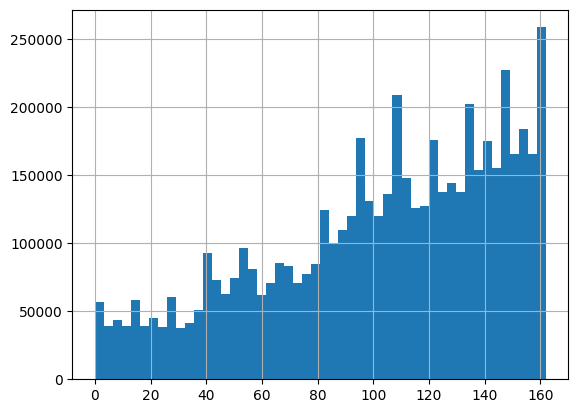

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
11,988709,7571,116,6558,100.0
69,804607,5220,120,171,0.0
114,806082,579,110,836,11.0
123,514235,8391,147,3570,57.0
162,231912,3363,122,444,7.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-9-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-9-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11..."
1,272,"[(12869, 40), (11310, 112)]"
2,448,"[(142, 95), (2256, 102), (13865, 104), (15297,..."
3,514,"[(5807, 113), (13865, 127)]"
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213..."
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214..."
2,448,"[(142, 95), (2256, 102), (13865, 104), (15297,...","[(6809, 158)]"
3,514,"[(5807, 113), (13865, 127)]","[(7728, 156), (1453, 158)]"
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]"


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[14119, 2080, 8656]"
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[14119, 2080, 8656]"
2,448,"[(142, 95), (2256, 102), (13865, 104), (15297,...","[(6809, 158)]","[14119, 2080, 8656]"
3,514,"[(5807, 113), (13865, 127)]","[(7728, 156), (1453, 158)]","[14119, 2080, 8656]"
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]","[14119, 2080, 8656]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [12]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None):

    if topn is None:
        topn = len(predictions)

    predictions = np.array(predictions[:topn])
    gt_items = set(gt_items)

    # массив релевантности
    relevance = np.isin(predictions, list(gt_items)).astype(int)

    cumulative_relevance = np.cumsum(relevance)

    precision_at_k = cumulative_relevance / (np.arange(len(relevance)) + 1)

    average_precision = np.sum(precision_at_k * relevance) / min(topn, len(gt_items))

    return average_precision

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None):

    if topn is None:
        topn = len(predictions)

    predictions = np.array(predictions[:topn])
    gt_items = set(gt_items)

    # позиция первого релевантного элемента
    relevance = np.isin(predictions, list(gt_items)).astype(int)
    first_relevant_index = np.argmax(relevance) if np.any(relevance) else -1

    if first_relevant_index == -1:
        return 0.0

    return 1.0 / (first_relevant_index + 1)

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None):

    if topn is None:
        topn = len(predictions)

    predictions = np.array(predictions[:topn])
    gt_items = set(gt_items)

    relevance = np.isin(predictions, list(gt_items)).astype(int)
    return 1 if np.any(relevance) else 0

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [13]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0001833333333333333, 'mrr': 0.0005166666666666666, 'hr': 0.0013}

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,448,"[(142, 95), (2256, 102), (13865, 104), (15297,...","[(6809, 158)]","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,514,"[(5807, 113), (13865, 127)]","[(7728, 156), (1453, 158)]","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.0685927027903754, 'mrr': 0.12637801587301586, 'hr': 0.3107}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        item_counts = {}

        all_timestamps = [timestamp for row in df[col] for _, timestamp in row]

        latest_time = max(all_timestamps) if all_timestamps else 0

        time_threshold = latest_time - self.min_window

        for _, row in df.iterrows():

            recent_interactions = [
                item for item in row[col] if item[1] > time_threshold
            ]

            if not recent_interactions:
                continue

            for item, _ in recent_interactions:
                if item in item_counts:
                    item_counts[item] += 1
                else:
                    item_counts[item] = 1

        sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [item for item, _ in sorted_items]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

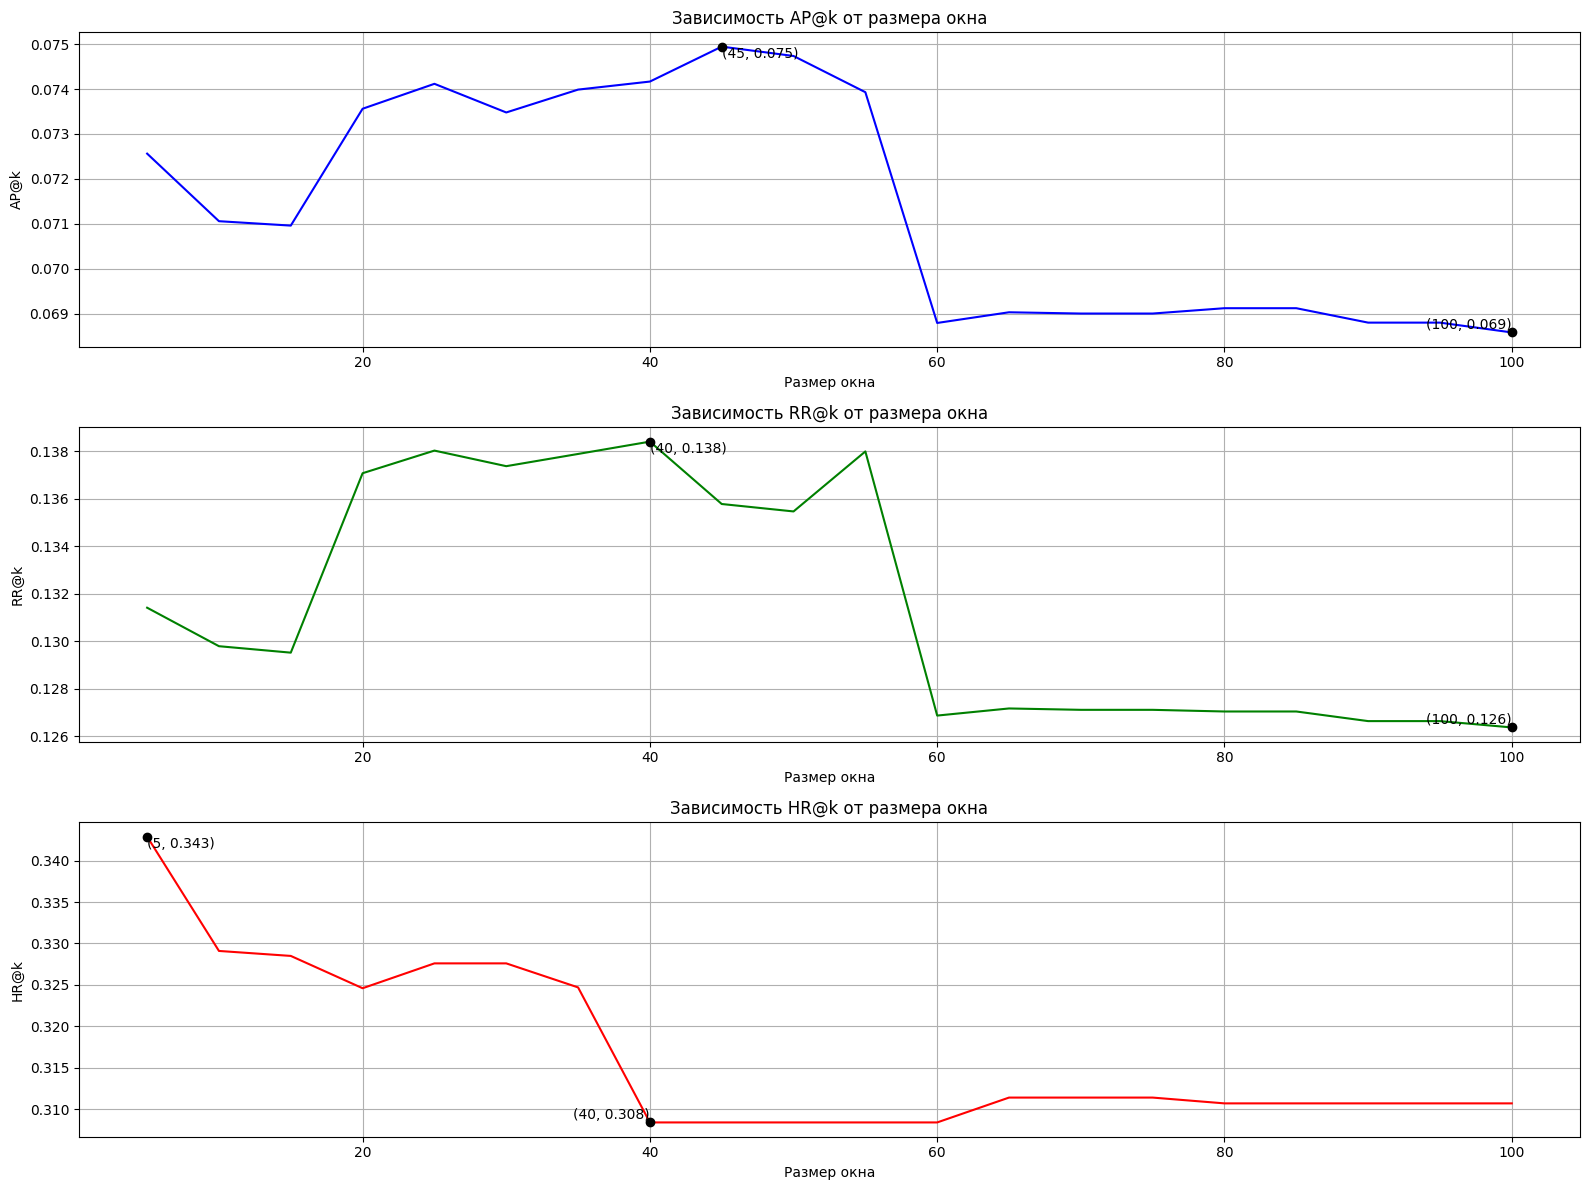

In [19]:
window_sizes = list(range(5, 101, 5))

ap_results = []
rr_results = []
hr_results = []

for window_size in window_sizes:
    model = TopPopularWeighted(min_window=window_size)
    model.fit(joined)

    toppopular_recs = model.predict(joined)

    ap = np.mean([ap_metric([item for item, _ in row['test_interactions']], toppopular_recs[i], topn=10) for i, row in joined.iterrows()])
    rr = np.mean([rr_metric([item for item, _ in row['test_interactions']], toppopular_recs[i], topn=10) for i, row in joined.iterrows()])
    hr = np.mean([hr_metric([item for item, _ in row['test_interactions']], toppopular_recs[i], topn=10) for i, row in joined.iterrows()])

    ap_results.append(ap)
    rr_results.append(rr)
    hr_results.append(hr)

plt.figure(figsize=(16, 12))

metrics = [('AP@k', ap_results, 'blue'), ('RR@k', rr_results, 'green'), ('HR@k', hr_results, 'red')]

for i, (title, results, color) in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    plt.plot(window_sizes, results, color=color)
    plt.title(f'Зависимость {title} от размера окна')
    plt.xlabel('Размер окна')
    plt.ylabel(title)

    ymin, ymax = min(results), max(results)
    min_idx, max_idx = np.argmin(results), np.argmax(results)
    min_x, max_x = window_sizes[min_idx], window_sizes[max_idx]

    plt.ylim(ymin - 0.05 * abs(ymax - ymin), ymax + 0.05 * abs(ymax - ymin))
    plt.grid(True)

    plt.scatter(min_x, ymin, color='black', zorder=3)
    plt.scatter(max_x, ymax, color='black', zorder=3)

    plt.text(min_x, ymin, f'({min_x}, {ymin:.3f})', verticalalignment='bottom', horizontalalignment='right', fontsize=10)
    plt.text(max_x, ymax, f'({max_x}, {ymax:.3f})', verticalalignment='top', horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Маленькое окно (в 5 дней) позволяет модели учитывать только последние популярные айтемы, что хорошо для короткосрочных интересов (AP@k, HR@k). Среднее окно (в 35 дней) дает лучший копросмисс между старыми и новыми, т.е. учитывая как недавние, так и немного устаревшие популярные айтемы, что повышает RR@k. Большие окна (>50 дней) включают слишком много старых данных, что снижает метрики.  
**Если резюмировать:** для точных, короткосрочных рекомендаций лучше выбирать минимальное окно, а для более сбалансированных рекомендаций подходит средний размер окна.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [20]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

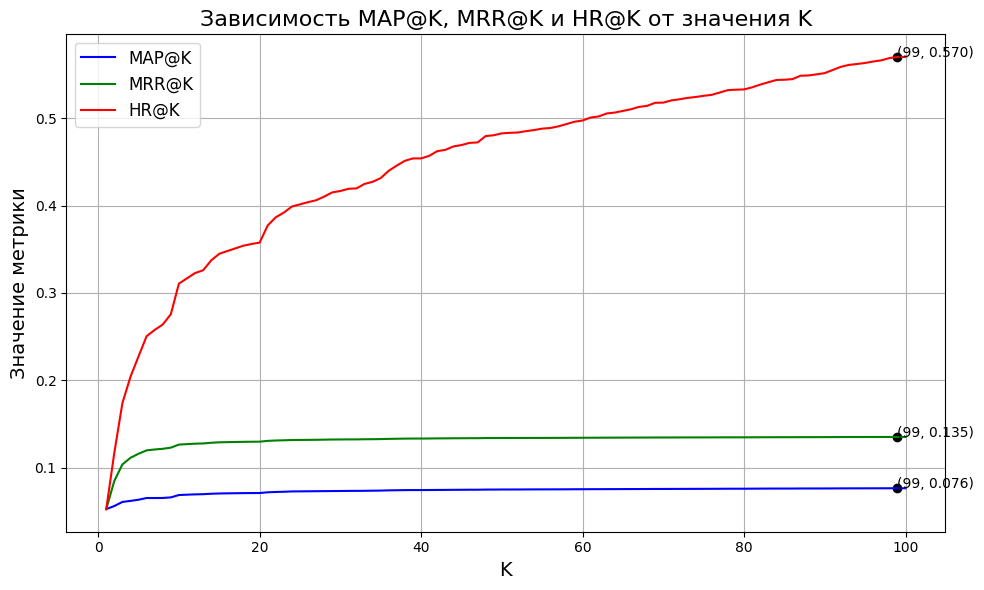

In [21]:
k_values = range(1, 101)

map_values = []
mrr_values = []
hr_values = []

for k in k_values:
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    metrics = evaluate_recommender(joined, 'toppopular_recs')
    map_values.append(metrics['map'])
    mrr_values.append(metrics['mrr'])
    hr_values.append(metrics['hr'])

plt.figure(figsize=(10, 6))

plt.plot(k_values, map_values, label="MAP@K", color='blue')
plt.scatter(np.argmax(map_values) + 1, max(map_values), color='black')
plt.text(np.argmax(map_values) + 1, max(map_values), f"({np.argmax(map_values)+1}, {max(map_values):.3f})")

plt.plot(k_values, mrr_values, label="MRR@K", color='green')
plt.scatter(np.argmax(mrr_values) + 1, max(mrr_values), color='black')
plt.text(np.argmax(mrr_values) + 1, max(mrr_values), f"({np.argmax(mrr_values)+1}, {max(mrr_values):.3f})")

plt.plot(k_values, hr_values, label="HR@K", color='red')
plt.scatter(np.argmax(hr_values) + 1, max(hr_values), color='black')
plt.text(np.argmax(hr_values) + 1, max(hr_values), f"({np.argmax(hr_values)+1}, {max(hr_values):.3f})")

plt.xlabel("K", fontsize=14)
plt.ylabel("Значение метрики", fontsize=14)
plt.title("Зависимость MAP@K, MRR@K и HR@K от значения K", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**   
*HR@k* - монотонно возрастает, так как с увеличением k растет вероятность найти релевантный айтем.  
*MAP@k* - монотонно возрастает, так как учитывает позиции релевантных айтемов.  
*MRR@k* - не всегда монотонна, зависит от ранга первого релевантного айтема.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**   
*HR@k* - быстрый рост означает, что пользователь быстро находит релевантный контент при скроллинге.  
*MAP@k* - рост показывает, что релевантные айтемы ближе к началу списка, что удобно для быстрого поиска.   
*MRR@k* - высокое значение указывает, что первый релевантный айтем находится близко к началу.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**   
*HR@k* - график должен возрастать с увеличением k, т.к. вероятность нахождения хотя бы одного релевантного айтема увеличивается. Скорость роста зависит от распределения релевантных айтемов в списке рекомендаций.  
*MAP@k* - график также должен возрастать, но скорость роста может замедляться, если релевантные айтемы находятся на более поздних позициях. Это связано с тем, что точность учитывает позиции релевантных айтемов.   
*MRR@k* - график может не монотонно возрастать, т.к. он зависит от ранга первого релевантного айтема. Если первый релевантный айтем находится на ранней позиции, увеличение k может не сильно повлиять на MRR.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [22]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

Королевство кривых зеркал


<Axes: >

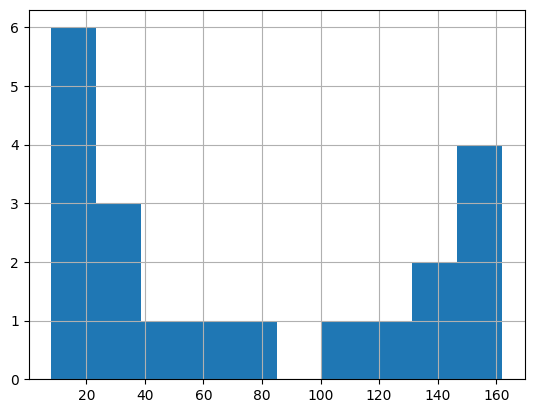

In [23]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 1917

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

> Посмотрим на случайные фильмы среди популярных:

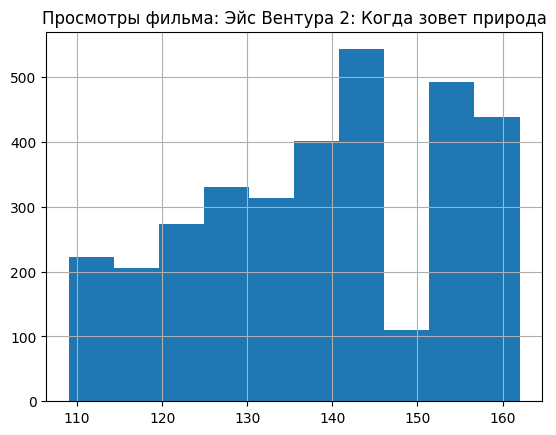

In [24]:
np.random.seed(10)

popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)
name = items.loc[items.item_id == sampled_id].title.values[0]

interactions = df.loc[df.item_id == sampled_id].copy()
interactions.last_watch_dt.hist()
plt.title(f"Просмотры фильма: {name}")
plt.show()

> Тут наблюдается рост популярности, потом резкий спад, а потом опять резкий подъем. Возможно, это связано с тем, что в это время вышла другая крпуная новинка и внимание пользователей переключилось на другой фильм.

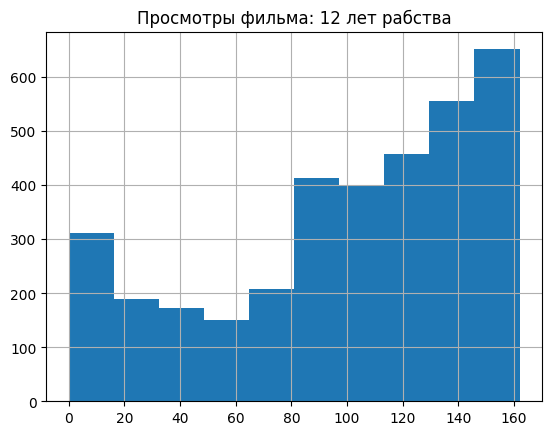

In [25]:
np.random.seed(15)

popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)
name = items.loc[items.item_id == sampled_id].title.values[0]

interactions = df.loc[df.item_id == sampled_id].copy()
interactions.last_watch_dt.hist()
plt.title(f"Просмотры фильма: {name}")
plt.show()

> Тут достаточно плавный рост попуряности, фильм начали смотреть, рекомендовать другим и просмотры выросли.

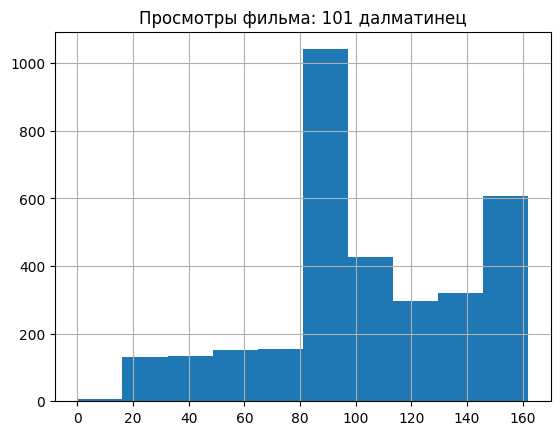

In [26]:
np.random.seed(20)

popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)
name = items.loc[items.item_id == sampled_id].title.values[0]

interactions = df.loc[df.item_id == sampled_id].copy()
interactions.last_watch_dt.hist()
plt.title(f"Просмотры фильма: {name}")
plt.show()

Тут заметен сильный рост летом, возможно, дети на каникулах чаще смотрят этот фильм.

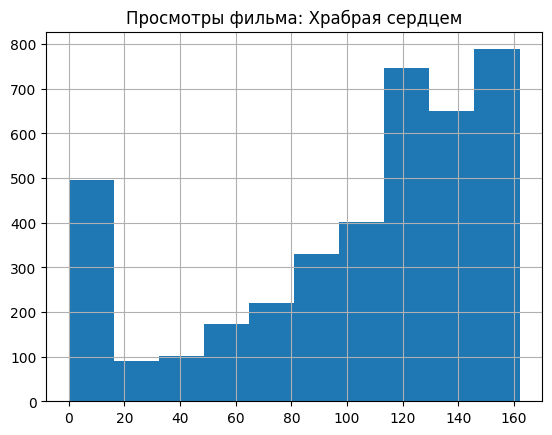

In [27]:
np.random.seed(60)

popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)
name = items.loc[items.item_id == sampled_id].title.values[0]

interactions = df.loc[df.item_id == sampled_id].copy()
interactions.last_watch_dt.hist()
plt.title(f"Просмотры фильма: {name}")
plt.show()

> Тут похожая история: летом дети чаще смотрят кино, но вот с чем связан рост в самом начале - непонятно.


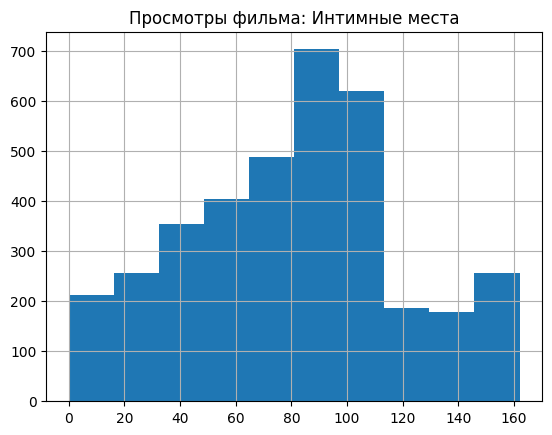

In [28]:
np.random.seed(150)

popular_items = df.item_id.value_counts()[:300].index.tolist()

sampled_id = np.random.choice(popular_items)
name = items.loc[items.item_id == sampled_id].title.values[0]

interactions = df.loc[df.item_id == sampled_id].copy()
interactions.last_watch_dt.hist()
plt.title(f"Просмотры фильма: {name}")
plt.show()

>Тут заметно, что фильм набирал постепенно популярность, потом просмотры стали падать, что свойственно любому фильму, когда популярность по-тихоньку начинает спадать.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [29]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    counts = df[col].value_counts()
    values_to_keep = counts[counts >= min_freq].index
    df = df[df[col].isin(values_to_keep)]

    return df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    filtered_df = df.copy()
    while True:
        n_rows_before = filtered_df.shape[0]

        for col in cols:
            filtered_df = filter_column(filtered_df, col, min_freq)

        n_rows_after = filtered_df.shape[0]

        if n_rows_after == n_rows_before:
            break

    return filtered_df

filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=5)

In [30]:
item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

filtered_train['user_id'] = filtered_train.user_id.apply(lambda x: user2id[x])
filtered_train['item_id'] = filtered_train.item_id.apply(lambda x: item2id[x])

filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1232317,2457,54,109,3037,42.0
4828190,3178,692,106,41,1.0
5021072,5049,648,146,16482,100.0
1083613,1254,774,110,12524,100.0
2941738,711,11,146,59145,80.0


In [31]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)

matrix

<5836x3076 sparse matrix of type '<class 'numpy.float64'>'
	with 105273 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

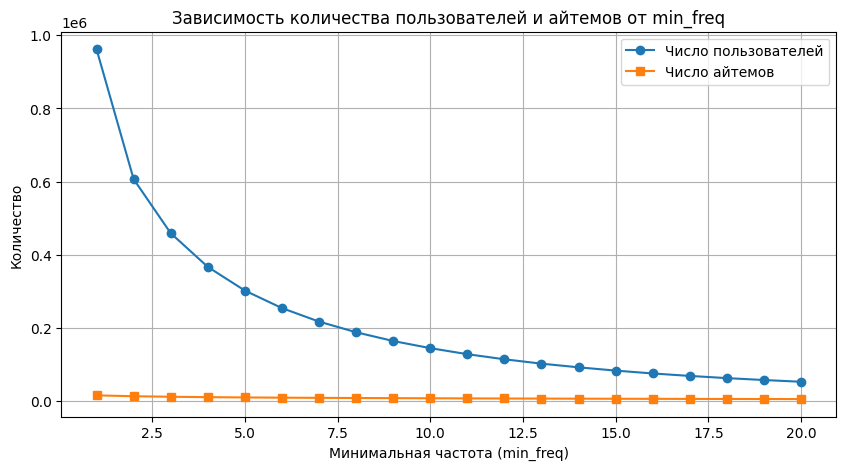

In [32]:
min_freq_values = range(1, 21)

num_users = []
num_items = []

for min_freq in min_freq_values:
    filtered_data = filter_dataframe(df, ['user_id', 'item_id'], min_freq=min_freq)
    num_users.append(filtered_data['user_id'].nunique())
    num_items.append(filtered_data['item_id'].nunique())

plt.figure(figsize=(10, 5))
plt.plot(min_freq_values, num_users, marker='o', label="Число пользователей")
plt.plot(min_freq_values, num_items, marker='s', label="Число айтемов")

plt.xlabel("Минимальная частота (min_freq)")
plt.ylabel("Количество")
plt.title("Зависимость количества пользователей и айтемов от min_freq")
plt.legend()
plt.grid(True)
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [33]:
%%time

def fit_ease(X, reg_weight=100):

  G = X.T @ X
  G += reg_weight * sps.identity(G.shape[0])
  G = G.todense()

  P = np.linalg.inv(G)
  B = P / (-np.diag(P))

  np.fill_diagonal(B, 0.)

  return B

w = fit_ease(matrix)

CPU times: user 4.78 s, sys: 492 ms, total: 5.27 s
Wall time: 3 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [34]:
def get_preds(x, item2id, id2item):
    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded == 1] = -np.inf

    ranks = np.argsort(-preds)

    decoded = [id2item[t] for t in ranks if t in id2item][:100]

    return decoded

joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))

In [35]:
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,ease_preds
0,241,"[(5051, 9), (2134, 9), (13913, 112), (6646, 11...","[(6162, 156), (10440, 156), (8986, 156), (1213...","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[5411, 12743, 15266, 3182, 565, 334, 10761, 16..."
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[8636, 7571, 13018, 12173, 12275, 4880, 10942,..."
2,448,"[(142, 95), (2256, 102), (13865, 104), (15297,...","[(6809, 158)]","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 4151, 13865, 9728, 3734, 15297, 9996, ..."
3,514,"[(5807, 113), (13865, 127)]","[(7728, 156), (1453, 158)]","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 3734, 12995, 15297, 8636, 4880, ..."
4,587,"[(4151, 64), (1400, 64), (4880, 69), (5658, 70...","[(11118, 153), (6192, 154)]","[14119, 2080, 8656]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[13865, 10440, 4880, 3734, 12995, 9728, 4151, ..."


In [36]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.07639775652069286, 'mrr': 0.13418904131186754, 'hr': 0.5677}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** EASE показывает лучшие результаты по всем метрикам. Особенно значительное преимущество у HR: 56.77% против 31% у TopPopular, что означает, что EASE чаще попадает в релеватные айтемы.

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

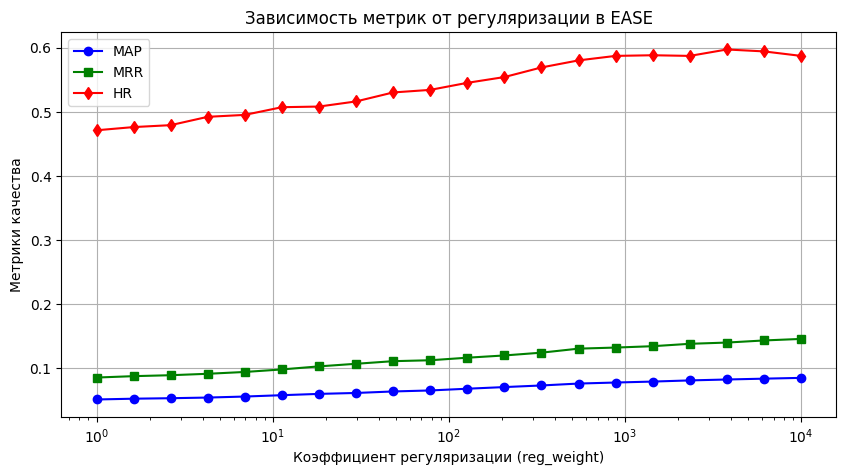

In [37]:
reg_values = np.logspace(0, 4, 20)
hit_rates = []
map_scores = []
mrr_scores = []

w_cache = {reg: fit_ease(matrix, reg_weight=reg) for reg in reg_values}

for reg in reg_values:
    w = w_cache[reg]

    sampled_users = joined.sample(frac=0.1, random_state=42)

    sampled_users['ease_preds'] = sampled_users.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))

    metrics = evaluate_recommender(sampled_users, model_preds='ease_preds')

    map_scores.append(metrics['map'])
    mrr_scores.append(metrics['mrr'])
    hit_rates.append(metrics['hr'])

plt.figure(figsize=(10, 5))
plt.plot(reg_values, map_scores, marker='o', color='blue', label="MAP")
plt.plot(reg_values, mrr_scores, marker='s', color='green', label="MRR")
plt.plot(reg_values, hit_rates, marker='d', color='red', label="HR")

plt.xscale("log")
plt.xlabel("Коэффициент регуляризации (reg_weight)")
plt.ylabel("Метрики качества")
plt.title("Зависимость метрик от регуляризации в EASE")
plt.legend()
plt.grid(True)
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:** наилучшее значение гиперпараметра ~10⁴, при данном значение HR достигает примерно 0.60 (60%).

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** при малых значениях reg_weight наблюдается быстрый рост HR. При значение reg_weight 10⁴ все метрики выходят на плато, можно предположить, что дальнейшее увеличение коэфф. регуляризации практически не улучшит метрики. Также, можно заметить, что при увеличении reg_weight значение метрик не ухудшается, это говорит о том, что модель устойчива к переобучению.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

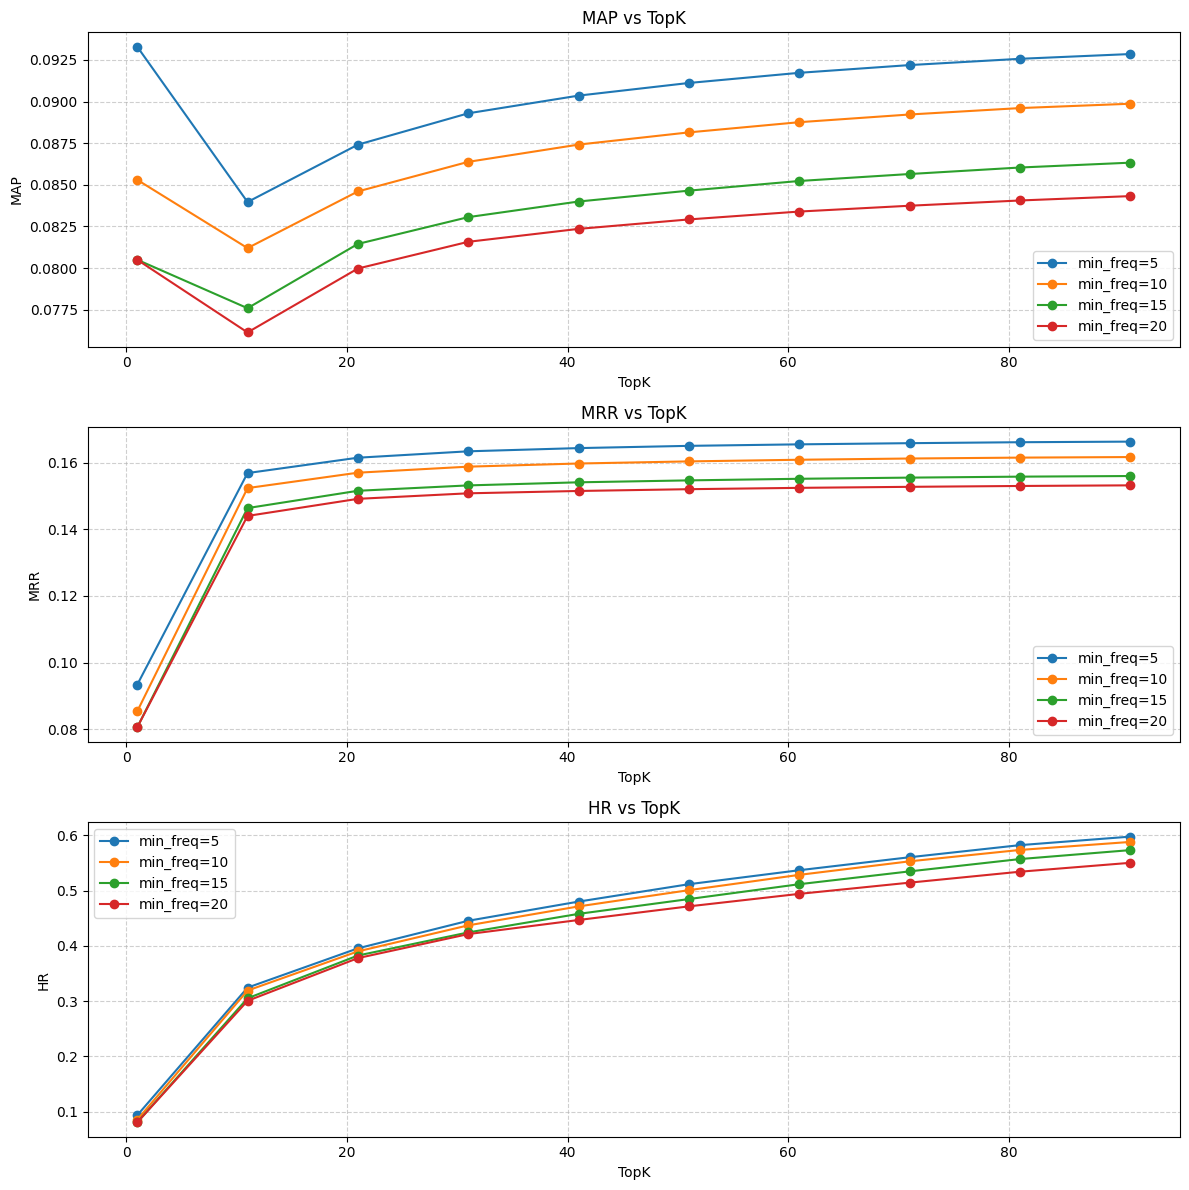

In [38]:
freq_array = [5, 10, 15, 20]
results = {mf: {'map': [], 'mrr': [], 'hr': []} for mf in freq_array}
topk_values = list(range(1, 101, 10))

def plot_metrics(results, freq_array, topk_values):
    plt.figure(figsize=(12, 12))

    plt.subplot(3, 1, 1)
    for mf in freq_array:
        plt.plot(topk_values, results[mf]['map'], label=f"min_freq={mf}", marker='o', linestyle='-')
    plt.title("MAP vs TopK")
    plt.xlabel("TopK")
    plt.ylabel("MAP")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.subplot(3, 1, 2)
    for mf in freq_array:
        plt.plot(topk_values, results[mf]['mrr'], label=f"min_freq={mf}", marker='o', linestyle='-')
    plt.title("MRR vs TopK")
    plt.xlabel("TopK")
    plt.ylabel("MRR")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.subplot(3, 1, 3)
    for mf in freq_array:
        plt.plot(topk_values, results[mf]['hr'], label=f"min_freq={mf}", marker='o', linestyle='-')
    plt.title("HR vs TopK")
    plt.xlabel("TopK")
    plt.ylabel("HR")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

for min_freq in freq_array:

    filtered_train = filter_dataframe(train_df, ['user_id', 'item_id'], min_freq=min_freq)

    item2id = {k: v for v, k in enumerate(filtered_train.item_id.unique())}
    user2id = {k: v for v, k in enumerate(filtered_train.user_id.unique())}

    id2item = {k: v for v, k in item2id.items()}
    id2user = {k: v for v, k in user2id.items()}

    filtered_train['user_id'] = filtered_train.user_id.map(user2id)
    filtered_train['item_id'] = filtered_train.item_id.map(item2id)

    matrix = sps.coo_matrix(
        (np.ones(filtered_train.shape[0]),
         (filtered_train['user_id'], filtered_train['item_id'])),
        shape=(len(user2id), len(item2id))
    )

    w = fit_ease(matrix, reg_weight=10000)

    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))

    for k in topk_values:

        joined['ease_preds_topk'] = joined['ease_preds'].apply(lambda x: x[:k])
        scores = evaluate_recommender(joined, model_preds='ease_preds_topk')

        results[min_freq]['map'].append(scores['map'])
        results[min_freq]['mrr'].append(scores['mrr'])
        results[min_freq]['hr'].append(scores['hr'])

plot_metrics(results, freq_array, topk_values)

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** графики соответствуют ожиданиям и подтверждают, что качество рекомендаций зависит от выбранного TopK и параметров фильтрации.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [39]:
import random

def print_recommendations_for_random_items(item2id, id2item, items, w, num_recommendations=5, num_samples=10, random_seed=42):
    random.seed(random_seed)

    random_items = random.sample(list(items['item_id']), num_samples)

    for item_id in random_items:
        item_title = items[items['item_id'] == item_id]['title'].values[0]
        print(f"Рекомендации для фильма '{item_title}':")

        recommended_items = get_preds([(item_id, 0)], item2id, id2item)[:num_recommendations]

        for recommended_item in recommended_items:
            recommended_title = items[items['item_id'] == recommended_item]['title'].values[0]
            print(f"  - {recommended_title}")
        print("\n")

print_recommendations_for_random_items(item2id, id2item, items, w, random_seed=42)

Рекомендации для фильма 'Медсестра (полная версия)':
  - Отверженные
  - Рассказы
  - Академия вампиров
  - Звёздный крейсер «Галактика» (мини-сериал)
  - Герои. Закалённые северной широтой


Рекомендации для фильма 'Кавардак':
  - Отверженные
  - Рассказы
  - Академия вампиров
  - Звёздный крейсер «Галактика» (мини-сериал)
  - Герои. Закалённые северной широтой


Рекомендации для фильма 'Спасти рядового Переса':
  - Отверженные
  - Рассказы
  - Академия вампиров
  - Звёздный крейсер «Галактика» (мини-сериал)
  - Герои. Закалённые северной широтой


Рекомендации для фильма 'Безжалостный город':
  - Отверженные
  - Рассказы
  - Академия вампиров
  - Звёздный крейсер «Галактика» (мини-сериал)
  - Герои. Закалённые северной широтой


Рекомендации для фильма 'Люди Икс: Первый класс':
  - Чёрная пантера
  - Прабабушка легкого поведения
  - Мстители: Финал
  - Мстители: Война бесконечности
  - Люди Икс 2


Рекомендации для фильма 'Тайна корабельных часов':
  - Отверженные
  - Рассказы
  - Ак

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** для каких-то фильмов рекомендации получились хорошие, напрмиер, для фильма "Люди Икс: Первый класс" рекомендуются другая часть "Люди Икс" и другие фильмы про супер-героев. Плохими можно назвать рекомендации, которые просто являются популярными, но по тематике и интересам пользователя не очень релеватные. Также, плохими рекомендациями можно назвать те фильмы, которые пользователь уже посмотрел.  
Что еще могу отметить: многие фильмы повторяются как рекомендованные, что тоже нехорошо.